### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import gpytorch as gp

from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.interpolate import CubicSpline

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils.plotting_utils import set_plotting_hyperparameters, truncate_colormap
from utils.data_gen_utils import sample_gp_prior, normalise
from utils.gp_models import ApproximateGPModel
from utils.train_utils import train
from utils.prediction_utils import predict, pdf_num_sigma
from utils.source_time_fns import ricker_wavelet, gaussian_derivative, sinusoidal_decay, double_couple
from utils.wave_propagation import pml_damping_profile, finite_difference_solver

### Plotting utilities

In [3]:
# set plotting hyperparameters
set_plotting_hyperparameters()

# set colors
colors = ["#002147", "#E2C044", "#DE1F1F"]

blue_cmap = LinearSegmentedColormap.from_list("custom_cmap", [colors[0], "#ffffff"])

# Truncate the colormap
blue_cmap = truncate_colormap(blue_cmap, 0., 0.8)

## Workflow

### Input data generation

In [4]:
def set_seed(seed):

    torch.manual_seed(seed)
    np.random.seed(seed)

    
seed = 0
set_seed(seed)

In [5]:
domain_size = 4
n_points = 25   # number of data points per input velocity model

# minimum and maximum seismic wave speeds in arbitrary units
min_velocity = 3
max_velocity = 7

In [6]:
# create a staggered coordinate grid
# GPs can handle non-gridded data, but we use regularly spaced
# data here for simplicity

x1 = torch.linspace(0., 3.9, n_points)  # coordinates of the first input velocity model
x2 = torch.linspace(0.1, 4., n_points)  # coordinates of the second input velocity model

xs = [x1, x2]

In [7]:
n_samples = len(xs)
lengthscale = [0.6, 0.3]    # lengthscale of the kernel function for each input velocity model

# generate velocity models as samples from the GP prior
velocity_models = sample_gp_prior(gp.kernels.RBFKernel(), lengthscale, n_samples=n_samples, x_samples=xs)

print(velocity_models.shape)

torch.Size([2, 25])


In [8]:
# second velocity model is a weighted superposition of the two GP samples
# this creates large-scale similarities and smaller-scale differences between the two models
velocity_models[1] = (1 / 3) * velocity_models[1] + (2 / 3) * velocity_models[0]

# normalise the velocity models to the desired range
velocity_models = normalise(velocity_models, min_velocity, max_velocity)

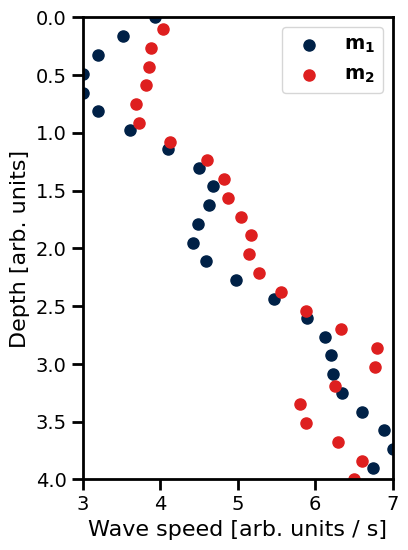

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
ax.scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

ax.set(ylim=(0, 4), xlim=(min_velocity, max_velocity))
ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

ax.invert_yaxis()

ax.legend()

plt.show()

### Training the models

In [10]:
# set the training data
train_x = torch.cat([x for x in xs], dim=0)
train_y = torch.cat([y for y in velocity_models], dim=0)

print(train_x.shape, train_y.shape)

torch.Size([50]) torch.Size([50])


In [11]:
# set initial locations of the inducing points
num_inducing_points = 20
inducing_points = torch.linspace(0, 4, num_inducing_points)

In [12]:
# Create models for each of the following kernels: RBF, Matern12, Matern32, Matern52, RQ, SpectralMixture

kernels = {
    "rbf": gp.kernels.RBFKernel(),
    "matern12": gp.kernels.MaternKernel(nu=0.5),
    "matern32": gp.kernels.MaternKernel(nu=1.5),
    "matern52": gp.kernels.MaternKernel(nu=2.5),
    "rq": gp.kernels.RQKernel(),
    "sm": gp.kernels.SpectralMixtureKernel(num_mixtures=4),
}

# create a dictionary to store the models
models = {}
likelihoods = {}

for kernel_name, kernel in kernels.items():
    
    # create PPGPR and SVGP models for each kernel
    ppgpr_model = ApproximateGPModel(
        inducing_points=deepcopy(inducing_points),
        kernel=deepcopy(kernel),
    )

    svgp_model = ApproximateGPModel(
        inducing_points=deepcopy(inducing_points),
        kernel=deepcopy(kernel),
    )

    # store the models in the dictionary
    models["ppgpr_" + kernel_name] = ppgpr_model
    models["svgp_" + kernel_name] = svgp_model

    # create likelihoods for each model
    likelihoods["ppgpr_" + kernel_name] = gp.likelihoods.GaussianLikelihood()
    likelihoods["svgp_" + kernel_name] = gp.likelihoods.GaussianLikelihood()

In [13]:
learning_rate = 0.05
training_iterations = 4000

In [14]:
# # train the models

# for model_name, model in models.items():

#     likelihood = likelihoods[model_name]

#     if "ppgpr" in model_name:
#         models[model_name], likelihoods[model_name] = train(
#             model_name,
#             model,
#             likelihood,
#             train_x,
#             train_y,
#             learning_rate,
#             training_iterations,
#             objective_type="ppgpr",
#         )
#     else:
#         models[model_name], likelihoods[model_name] = train(
#             model_name,
#             model,
#             likelihood,
#             train_x,
#             train_y,
#             learning_rate,
#             training_iterations,
#             objective_type="svgp",
#         )

#     # save the model and likelihood
#     torch.save(model.state_dict(), f"./trained_models/{model_name}.pth")
#     torch.save(likelihood.state_dict(), f"./trained_models/likelihood_{model_name}.pth")

In [15]:
# load the trained models and likelihoods

for model_name, model in models.items():

        likelihood = likelihoods[model_name]

        model.load_state_dict(torch.load(f"./trained_models/{model_name}.pth"))
        likelihood.load_state_dict(torch.load(f"./trained_models/likelihood_{model_name}.pth"))

        model.eval()
        likelihood.eval()

In [16]:
# Select model to use for prediction
# CAN CHANGE MODEL_CHOICE TO ANY OF THE FOLLOWING: "rbf", "matern12", "matern32", "matern52", "rq", "sm"

MODEL_CHOICE = "rbf"

svgp_model_name = "svgp_" + MODEL_CHOICE
ppgpr_model_name = "ppgpr_" + MODEL_CHOICE

svgp = models[svgp_model_name]
ppgpr = models[ppgpr_model_name]

likelihood_svgp = likelihoods[svgp_model_name]
likelihood_ppgpr = likelihoods[ppgpr_model_name]

### Generating model predictions

In [17]:
num_test_points = 201

test_x = torch.linspace(0, domain_size, num_test_points)

In [18]:
mean_ppgpr, std_ppgpr, out_samples_ppgpr = predict(
    model=ppgpr,
    x=test_x,
    likelihood=None,
    num_samples=3,
)

mean_svgp, std_svgp, out_samples_svgp = predict(
    model=svgp,
    x=test_x,
    likelihood=likelihood_svgp,
    num_samples=3,
)

In [19]:
test_velocities = torch.linspace(2., 8., num_test_points)

n_sigma_pdf_ppgpr = pdf_num_sigma(
    model=ppgpr,
    test_coordinates=test_x,
    test_velocities=test_velocities,
    likelihood=None,
    num_sigma_clip=5.,
)

n_sigma_pdf_svgp = pdf_num_sigma(
    model=svgp,
    test_coordinates=test_x,
    test_velocities=test_velocities,
    likelihood=likelihood_svgp,
    num_sigma_clip=5.,
)

### Generating samples of velocity models from PPGPR predictive distribution

In [20]:
# generate many samples of velocity models from the PPGPR predictive distribution
NUM_VMODEL_SAMPLES = 200

_, _, velocity_samples = predict(
    model=ppgpr,
    x=test_x,
    likelihood=None,
    num_samples=NUM_VMODEL_SAMPLES,
)

### Plotting GP fusion results

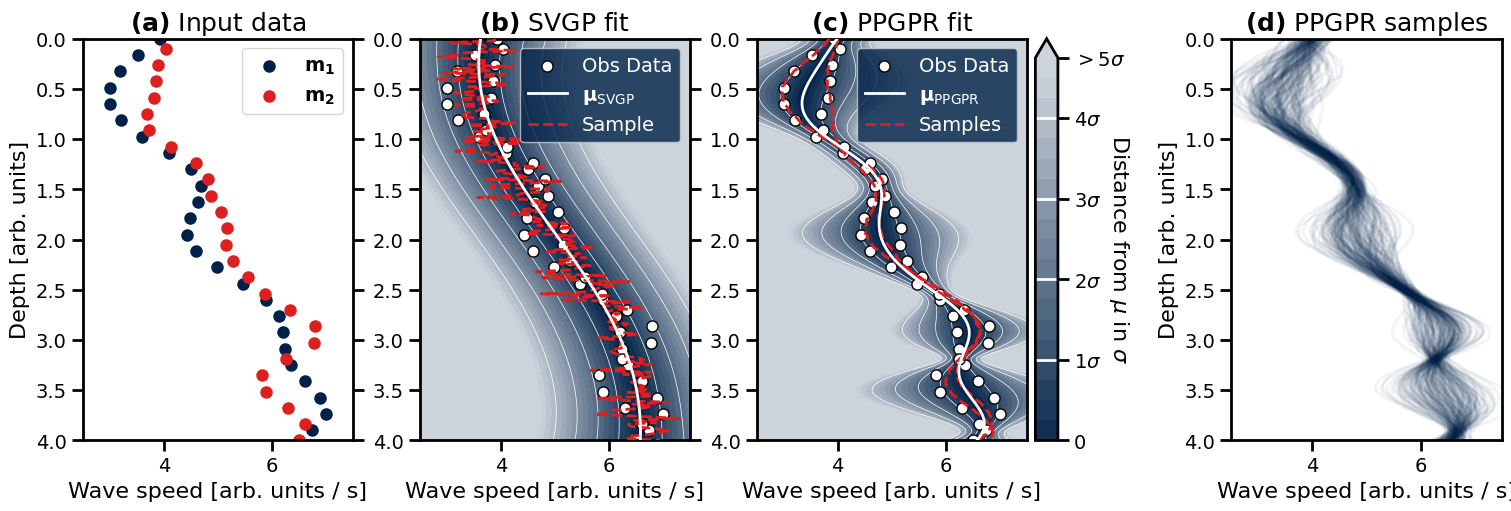

In [21]:
# plot the input data, the SVGP fit, the PPGPR fit, and the velocity samples from the PPGPR predictive distribution

gs_kw = dict(width_ratios=[12, 12, 12, 1, 0.5, 12])

fig, axs = plt.subplots(1, 6, figsize=(15, 5), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    if col == 0:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 1:
        ax.tick_params(right=True)

    if col != 3:
        ax.set_xlabel("Wave speed [arb. units / s]")

axs[0].scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
axs[0].scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

axs[0].legend(loc="upper right")

c = axs[1].contourf(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[1].contour(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[1].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[1].plot(mean_svgp, test_x, label=r"$\bf{\mu}_{\text{SVGP}}$", color="white", zorder=4)

axs[1].plot(out_samples_svgp[0], test_x, color=colors[2], ls="--", label=f"Sample", zorder=3)

axs[1].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

c = axs[2].contourf(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[2].contour(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[2].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[2].plot(mean_ppgpr, test_x, label=r"$\bf{\mu}_{\text{PPGPR}}$", color="white", zorder=4)

for i in range(2):
    if i == 0:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", label=f"Samples", zorder=3)
    else:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", zorder=3)

axs[2].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

cbar = fig.colorbar(c, cax=axs[3])
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels([r"0", r"1$\sigma$", r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"$>$5$\sigma$"])
cbar.set_label("Distance from $\mu$ in $\sigma$", rotation=270)

axs[3].invert_yaxis()

axs[4].axis("off")

for i in range(1, 5):
    cbar.ax.axhline(i, color="white", lw=2)

for i in range(NUM_VMODEL_SAMPLES):
    axs[5].plot(velocity_samples[i], np.linspace(0, 4, num_test_points), color=colors[0], alpha=0.05)

axs[5].set_ylabel("Depth [arb. units]")

axs[0].set_title(r"$\bf{(a)}$ Input data")
axs[1].set_title(r"$\bf{(b)}$ SVGP fit")
axs[2].set_title(r"$\bf{(c)}$ PPGPR fit")
axs[5].set_title(r"$\bf{(d)}$ PPGPR samples")

plt.show()

### Wave propagation (earthquake simulations)

In [22]:
# Wave propagation hyperparameters (CAN CHANGE SOURCE LOCATION - HIGHLIGHTED IN CAPS)

num_test_points = 201
dx = domain_size / (num_test_points - 1)
courant_number = 0.6
dt = courant_number * dx / max_velocity
nt = 600

time = np.arange(nt) * dt
center_frequency = 12. / (nt * dt)
time_shift = 1. / center_frequency

rise_time = 0.2 / center_frequency
duration = 2. / center_frequency
damping_factor = 10.

amplitude_scaling = 500.

SRC_IDX = int(num_test_points * 2 / 3)

#### Earthquake source

In [23]:
sources = {
    "ricker": ricker_wavelet(time, center_frequency, 2 * time_shift),
    "gaussian": gaussian_derivative(time, center_frequency, 2 * time_shift),
    "sinusoidal": sinusoidal_decay(time, center_frequency, time_shift, damping_factor),
    "double_couple": double_couple(time, center_frequency, rise_time, duration, time_shift),
}

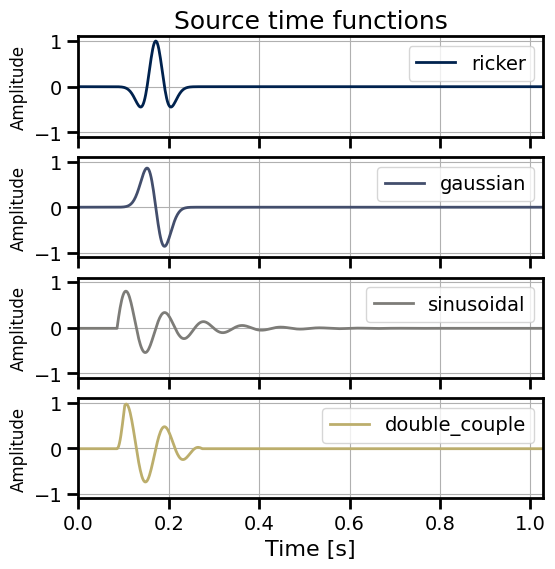

In [24]:
# plot the source time functions on four stacked subplots

fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True)

for i, (source_name, source) in enumerate(sources.items()):
    axs[i].plot(time, source, color=plt.get_cmap("cividis")(i / len(sources)), label=source_name)

    axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_xlim(0, nt * dt)

    axs[i].legend()

    axs[i].set_ylabel("Amplitude", fontsize=12)

    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_title("Source time functions")

    if i == 3:
        axs[i].set_xlabel("Time [s]")

plt.show()

In [25]:
# Select source to use for wave propagation
# CAN CHANGE SOURCE_CHOICE to any of the following: "ricker", "gaussian", "sinusoidal", "double_couple"

SOURCE_CHOICE = "ricker"

source = sources[SOURCE_CHOICE] * amplitude_scaling

#### Solving the wave equation for velocity model samples

In [26]:
num_pml_points = 25

damping = pml_damping_profile(
    num_coordinates=num_test_points,
    num_pml_points=num_pml_points,
    max_damping=20 * (1 + 2 * max_velocity / 3),
)  # PML damping profile


peak_amplitudes, plotting_wavefield = finite_difference_solver(
    velocity_models=velocity_samples,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=SRC_IDX,
    damping=damping,
)

100%|██████████| 600/600 [00:06<00:00, 92.15it/s] 


#### Solving wave equation for input velocity models

In [27]:
interpolated_models = np.zeros((2, num_test_points))

for i in range(2):
    cs = CubicSpline(xs[i], velocity_models[i])
    interpolated_models[i] = cs(np.linspace(0, 4, num_test_points))

peak_amplitudes_input_models, plotting_wavefield_input_models = finite_difference_solver(
    velocity_models=interpolated_models,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=SRC_IDX,
    damping=damping,
)

100%|██████████| 600/600 [00:03<00:00, 161.63it/s]


### Calculating probabilistic estimate of peak ground motion and plotting

In [28]:
# statistics of the PGD distribution

median = np.median(peak_amplitudes[:, -1])

# calculate the middle 70% of the PGD
lower_bound = np.percentile(peak_amplitudes[:, -1], 15)
upper_bound = np.percentile(peak_amplitudes[:, -1], 85)

upper_tenth_percentile = np.percentile(peak_amplitudes[:, -1], 90)

print(f"90th percentile: {upper_tenth_percentile:.2f}")

d_med_lower = median - lower_bound
d_med_upper = upper_bound - median

90th percentile: 0.92


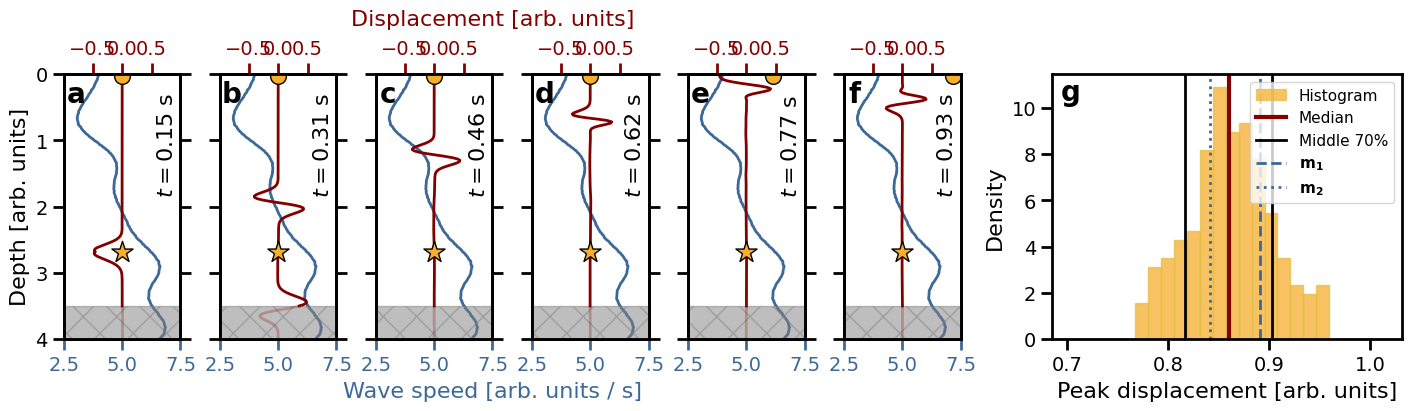

In [29]:
x = np.linspace(0., 4., num_test_points)

gs_kw = dict(width_ratios=[3, 3, 3, 3, 3, 3, 9])

fig, axs = plt.subplots(1, 7, figsize=(14, 4), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat[:-1]):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    ax2 = ax.twiny()

    ax2.set_xlim(- (median + 3 * d_med_upper), median + 3 * d_med_upper)

    if col == 5:
        pass
    else:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 2:
        ax2.set_xlabel("Displacement [arb. units]", color="#830000", labelpad=10, x=1)
        ax.set_xlabel("Wave speed [arb. units / s]", color="#3C6997", labelpad=5, x=1)

    if col != 0:
        ax.set_yticklabels([])

    ax.tick_params(axis='x', labelcolor="#3C6997", color="#3C6997")
    ax2.tick_params(axis='x', labelcolor="#830000", color="#830000")

    N = 90

    ax.text(0.8, 0.55, f"$t = {N * (1 + col) * dt:0.2f}$ s", transform=ax.transAxes, fontsize=16, rotation="vertical")

    ax2.plot(plotting_wavefield[N * (1 + col), :-num_pml_points], x[:-num_pml_points], color="#830000")
    ax2.plot(plotting_wavefield[N * (1 + col), -num_pml_points - 1:], x[-num_pml_points - 1:], color="#830000", alpha=0.25)
    ax.plot(velocity_samples[1], x, color="#3C6997")

    ax2.scatter(0, SRC_IDX * dx, color="#F6AE2D", marker="*", s=256, edgecolor="black", zorder=5)

    ax2.scatter(peak_amplitudes[1, N * (1 + col)], 0.025, color="#F6AE2D", marker="o", s=128, edgecolor="black", zorder=2)

    ax2.fill_between([-10., 10.], domain_size - num_pml_points * dx, 4, color="tab:grey", alpha=0.5, hatch="x")

axs[-1].hist(peak_amplitudes[:, -1], bins=15, density=True, color="#F6AE2D", alpha=0.75, label="Histogram", edgecolor=colors[1])

axs[-1].axvline(median, color="#830000", lw=3, label="Median")
axs[-1].axvline(lower_bound, color="black", lw=2, label="Middle 70%")
axs[-1].axvline(upper_bound, color="black", lw=2)

axs[-1].axvline(peak_amplitudes_input_models[0, -1], color="#3C6997", lw=2, ls="--", label=r"$\bf{m}_1$")
axs[-1].axvline(peak_amplitudes_input_models[1, -1], color="#3C6997", lw=2, ls=":", label=r"$\bf{m}_2$")

axs[-1].set_xlim([median - 4 * d_med_lower, median + 4 * d_med_upper])

# axs[-1].set_yticks([])
axs[-1].set_xlabel("Peak displacement [arb. units]", labelpad=5)
axs[-1].set_ylabel("Density", labelpad=5)

axs[-1].legend(fontsize=11, loc="upper right")

lposx = 0.1
lposy = 0.925

axs[0].text(lposx, lposy, r"$\bf{a}$", transform=axs[0].transAxes, fontsize=20, ha="center", va="center")
axs[1].text(lposx, lposy, r"$\bf{b}$", transform=axs[1].transAxes, fontsize=20, ha="center", va="center")
axs[2].text(lposx, lposy, r"$\bf{c}$", transform=axs[2].transAxes, fontsize=20, ha="center", va="center")
axs[3].text(lposx, lposy, r"$\bf{d}$", transform=axs[3].transAxes, fontsize=20, ha="center", va="center")
axs[4].text(lposx, lposy, r"$\bf{e}$", transform=axs[4].transAxes, fontsize=20, ha="center", va="center")
axs[5].text(lposx, lposy, r"$\bf{f}$", transform=axs[5].transAxes, fontsize=20, ha="center", va="center")
axs[6].text(0.05, lposy, r"$\bf{g}$", transform=axs[6].transAxes, fontsize=20, ha="center", va="center")

plt.show()

## Exercises

Below are three exercises to choose from. I recommend you tackle one of these exercises during this session in pairs. We will come back to share our findings at the end of the session!

### Exercise #1: Engineering implications - should they build a building?

#### Background

Assume that a construction company is wondering whether the site at the surface of our simulations is a safe place to build a building. According to their engineers, the building they are planning would be able to withstand a PGD of 1.7 (arbitrary units). They would give the go-ahead to construct it if there is less than a 10% chance that the PGD at this location will exceed 1.7. Should they build the building?

#### Instructions

Write some code to assess the probability (predicted by our simulations) that the PGD will exceed 1.7. Investigate how the following choices in our analysis and earthquake parameters affect your conclusions:

- The kernel (or covariance function) used to fit the PPGP to our input velocity models. The choice of covariance functions imposes prior knowledge about the spatial structure of samples from the distribution. Explore different covariance functions (e.g., Matern with different values for the "nu" parameter) and their impacts on PGD predictions.
- The earthquake source location. This determines the depth at which the earthquake occurs. Assume that earthquakes are uniformly likely to occur between depths of 2 and 3.5 (and unlikely at any other depths). Investigate how the distribution of PGD varies with earthquakes of different depths.

Try to evaluate whether or not they should build a building, accounting for the variability in your conclusions that result from the choice of GP covariance structure and earthquake source location.

In [30]:
# TODO: WRITE YOUR CODE FOR EXERCISE 1 HERE, AND ADD ADDITIONAL CELLS AS NEEDED. OPTION INSTEAD TO MODIFY THE CODE IN THE ABOVE WORKFLOW.

# -----



### Exercise #2: How much impact do inconsistencies between seismic velocity models have on PGD predictions?

#### Background

We highlight in the motivation for this work that there are inconsistencies between exisiting estimates of seismic velocities, and that making a subjective choice of which velocity model to use in earthquake simulations affects the results of ground motion predictions. Current physics-based seismic hazard workflows do not account for this source of uncertainty. Just how important is it to consider the variability in ground motion predictions caused by inconsistencies between seismic velocity models? Can small differences in velocities cause large differences in predicted ground motion? Given that this is a 1-D example, how would you expect (or not) your conclusions to change in 2-D and 3-D?

#### Instructions

1. Design a metric that enables a meaningful comparison of differences between velocity models, and differences between corresponding PGD predictions. I'd suggest percentage difference, for example (e.g., average percentage difference between two velocity models, and percentage difference between the corresponding PGD predictions), but get creative if you are up for it!
2. Write code to compare relative differences between the velocity model samples and the corresponding PGD predictions that result from using the velocity models in earthquake simulations. Are seismic velocity differences amplified or reduced in PGD predictions?
3. Can you quantify the sensitivity of PGD predictions with respect to differences in seismic velocities at different depths? In a sense - how does the impact of differences in seismic velocities on PGD measurements change with the depth of those differences (e.g., if you have a 10% change in seismic velocities close to the surface, does that have a smaller/larger impact on PGD than a 10% change in seismic velocities at a deeper point?). Can you plot this "sensitivity" with respect to depth?
4. Do your conclusions change if you use a different covariance function when fitting the PPGP to the two input velocity models? The covariance function imposes prior knowledge about the spatial structure of the data.
5. Would you expect your conclusions to change if the data and earthquake simulations were in 2-D or 3-D? No need to code anything up for this step, but feel free to write down your thoughts.

In [31]:
# TODO: WRITE YOUR CODE FOR EXERCISE 2 HERE, AND ADD ADDITIONAL CELLS AS NEEDED. OPTION INSTEAD TO MODIFY THE CODE IN THE ABOVE WORKFLOW.

# -----



### Exercise #3: Computational cost - how many simulations do we need to run?

#### Background

In this 1-D example, simulating many earthquakes is no problem in terms of time and computational requirements. In realistic applications, involving 3-D simulations of the elastic wave equation, it becomes very computationally expensive to run many earthquake simulations. What is the minimum number of simulations we need to run to appropriately capture the distribution of ground shaking scenarios, with respect to inconsistencies between existing seismic velocity models? How can we quantify this, and how sensitive is this number to the choices of hyperparameters we make during the workflow?

#### Instructions

1. Design a metric for assessing how well a certain number of simulations captures the distribution of possible ground shaking scenarios. For example, you could calculate the statistics of the histogram after each simulation, and have some method of stopping the simulations once the statistics stop changing by a certain amount. Get creative!
2. Does the required number of simulations change depending on e.g., what covariance function is used in fitting the PPGP or the location of the earthquake source?

In [32]:
# TODO: WRITE YOUR CODE FOR EXERCISE 3 HERE, AND ADD ADDITIONAL CELLS AS NEEDED. OPTION INSTEAD TO MODIFY THE CODE IN THE ABOVE WORKFLOW.

# -----

